In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [2]:
# Load the labels
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [3]:
labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [4]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

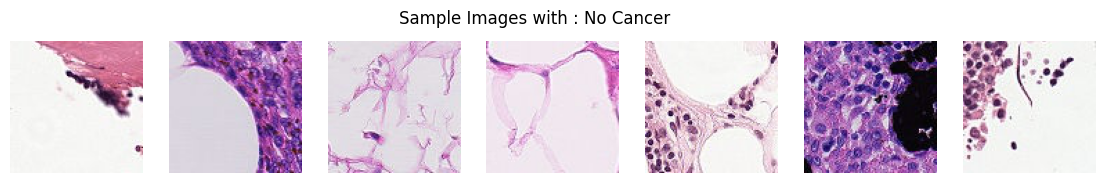

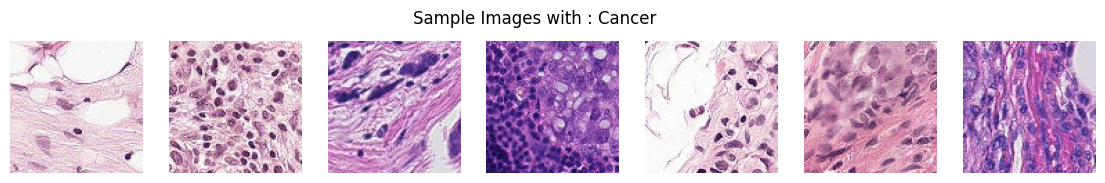

In [5]:
def show_samples(label, num_samples=7):
    # Mapping from numeric labels to descriptive strings
    label_mapping = {0: 'No Cancer', 1: 'Cancer'}
    label_name = label_mapping.get(label, 'Unknown')  # Get the descriptive label name

    # Get a random sample of images with the specified label
    sample_images = labels[labels['label'] == label].sample(num_samples)
    plt.figure(figsize=(14, 2))
    
    for i, img_name in enumerate(sample_images['id']):
        img_path = os.path.join(train_dir, img_name + '.tif')  # Construct the image path
        img = Image.open(img_path)  # Open the image
        plt.subplot(1, num_samples, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
        
    plt.suptitle(f'Sample Images with : {label_name}') 
    plt.show()


show_samples(label=0)  # Show samples for 'No Cancer'
show_samples(label=1)  # Show samples for 'Cancer'


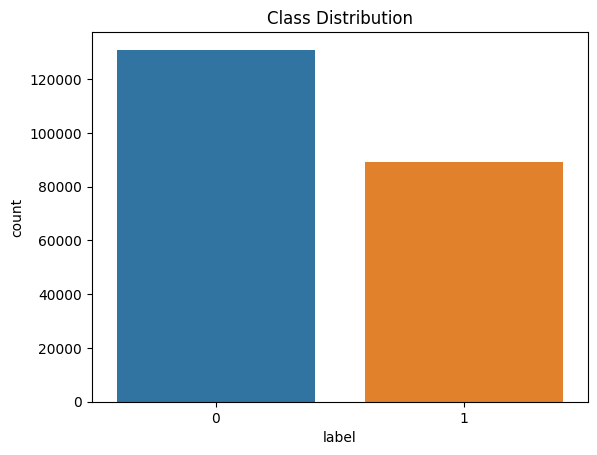

In [6]:
sns.countplot(x='label', data=labels)
plt.title('Class Distribution')
plt.show()

In [7]:
labels.isnull().sum()

id       0
label    0
dtype: int64

In [8]:
labels.shape

(220025, 2)

In [9]:
num_train_images = len(os.listdir(train_dir))
num_test_images = len(os.listdir(test_dir))

print(f'{num_train_images} pictures in train.')
print(f'{num_test_images} pictures in test.')

220025 pictures in train.
57458 pictures in test.


In [10]:
countzero = 0
countone = 0

In [11]:
for i in range(220025):
    if labels['label'][i] == 1:
        countone += 1
    else:
        countzero += 1

In [12]:
print(countone)
print(countzero)

89117
130908


In [13]:
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# Define the baseline model without input_shape in Conv2D
def create_baseline_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),  # Input layer with specified input shape
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Define the advanced model with the same change
def create_advanced_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),  # Input layer with specified input shape
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

advanced_model = create_advanced_model()
advanced_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 3. Splitting labels into training and validation
train_labels, val_labels = train_test_split(labels, test_size=0.2, stratify=labels['label'], random_state=17)
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)

# Adding .tif extension to match file names
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

In [17]:
# 4. Create ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True  # Randomly flip images vertically
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Validation data is only rescaled, no augmentation

# Flow images from dataframe for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [18]:
# 5. Compile models to define optimizer, loss, and evaluation metrics
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
advanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# 6. Train the models on the training data
# Compile and Train Baseline Model on GPU
# Wrap training loop with tqdm for additional progress visibility
with tqdm(total=len(train_generator), desc="Training Progress", unit="batch") as pbar:
    baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_baseline = baseline_model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        callbacks=[tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch, logs: pbar.update(1))]
    )


Training Progress:   0%|          | 0/5501 [00:00<?, ?batch/s]

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730142517.397603      68 service.cc:145] XLA service 0x7ab5540035b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730142517.397661      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/5501 ━━━━━━━━━━━━━━━━━━━━ 7:48 85ms/step - accuracy: 0.4792 - loss: 1.6288 

I0000 00:00:1730142519.895205      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1381s 250ms/step - accuracy: 0.7771 - loss: 0.4783 - val_accuracy: 0.8030 - val_loss: 0.4395
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 500s 91ms/step - accuracy: 0.8356 - loss: 0.3741 - val_accuracy: 0.8385 - val_loss: 0.3746
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 408s 74ms/step - accuracy: 0.8511 - loss: 0.3467 - val_accuracy: 0.8541 - val_loss: 0.3404
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 396s 72ms/step - accuracy: 0.8581 - loss: 0.3320 - val_accuracy: 0.8694 - val_loss: 0.3129
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 352s 64ms/step - accuracy: 0.8698 - loss: 0.3080 - val_accuracy: 0.8693 - val_loss: 0.3129


In [20]:
# Compile and Train Advanced Model on GPU
with tf.device('/GPU:0'):  # Use GPU if available
    advanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_advanced = advanced_model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator
    )

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 331s 59ms/step - accuracy: 0.7747 - loss: 0.4811 - val_accuracy: 0.8369 - val_loss: 0.3651
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 315s 57ms/step - accuracy: 0.8438 - loss: 0.3631 - val_accuracy: 0.8722 - val_loss: 0.3117
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 378s 69ms/step - accuracy: 0.8637 - loss: 0.3257 - val_accuracy: 0.8839 - val_loss: 0.2761
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 390s 71ms/step - accuracy: 0.8749 - loss: 0.3012 - val_accuracy: 0.8945 - val_loss: 0.2691
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 373s 68ms/step - accuracy: 0.8809 - loss: 0.2940 - val_accuracy: 0.8963 - val_loss: 0.2565


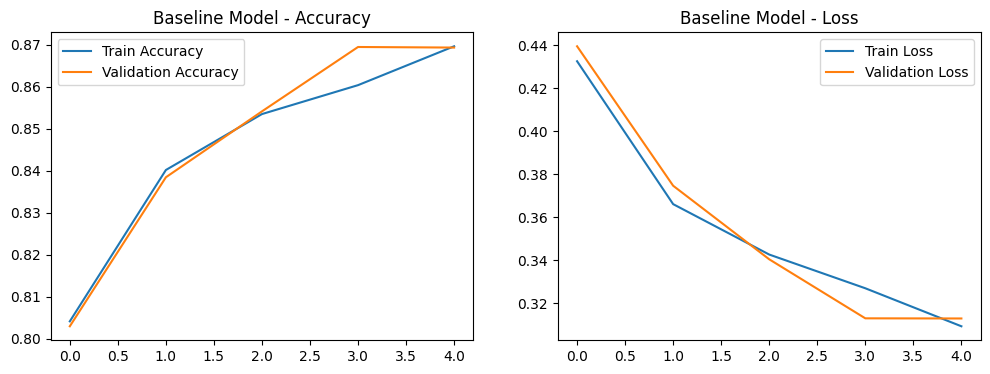

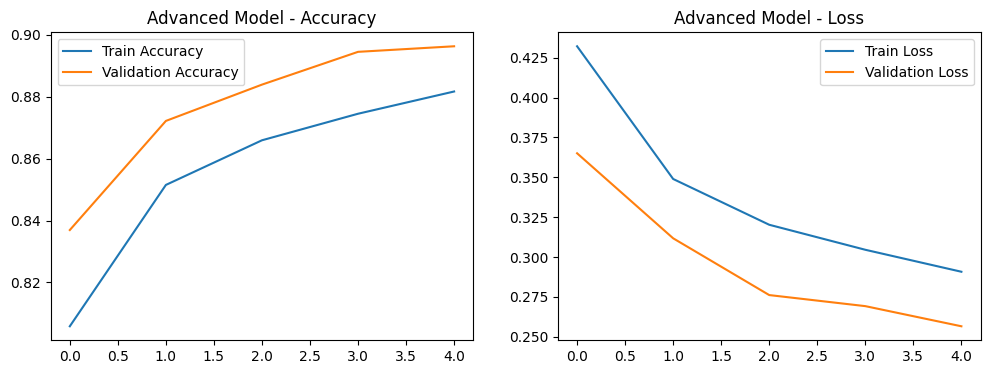

In [21]:

# 7. Function to plot training and validation history for both models
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

# Plot performance of both models
plot_history(history_baseline, 'Baseline Model')
plot_history(history_advanced, 'Advanced Model')

In [22]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
